In [1]:
%matplotlib inline

# math
import numpy as np
import numpy.ma as ma
import scipy as sc

# data
import xarray as xr
import pandas
import os
import os.path
import re
import nc_time_axis
import glob
import csv
from xgcm import Grid

#plotting 
import matplotlib as mpl 
import matplotlib.path as mpath
from matplotlib import pyplot as plt 
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import cmocean as cmo

import plotting_utils as plu
import Ngl as ngl

mpl.rcParams['font.size'] = 12

In [30]:
## WRITE A FUNCTION TO READ THE FILES INTO A GOOD FORMATION

In [17]:
# Define functions for regridding, summing over selected locations, and plotting

def vertical_regrid(ds,p_target):
    
    #define a Grid object for the data
    grid = Grid(ds,coords={'Z': {'center': 'lev'}}, periodic=False)
    
    #define pressure levels (# in line with CAM vertical resolution)
#     p_target = np.linspace(100,1010,32)
    p = (ds['hyam']*ds['P0'] + ds['hybm']*ds['PS'])/100
    
    ds = ds.assign({'p' : np.log(p)})
    
    #do the transformation using xgcm
    temp_on_pressure = grid.transform(ds.T, 'Z', np.log(p_target), target_data=ds.p, method='linear')
      
    temp_on_pressure = temp_on_pressure.rename({'p': 'plev'})
    temp_on_pressure = temp_on_pressure.assign_coords({'plev': p_target})
    
    return temp_on_pressure


def sum_selection(ds):
    SEL = (ds.T * ds.gw).sum(dim=['lat','lon']) / ((ds.gw * ds.T / ds.T).sum(dim=['lat','lon']))
    
    return SEL
   

def plot_temp_profiles(tempc, tempp, hemisphere, seas, latbound, ylim, xlim, fixed):
    
    fig = plt.figure(figsize = (8,8))
    
    if hemisphere == "South":
        latbound = -1*latbound
        tempc = tempc.where(tempc.lat < latbound)
        tempp = tempp.where(tempp.lat < latbound)
    else:
        tempc = tempc.where(tempc.lat > latbound)
        tempp = tempp.where(tempp.lat > latbound)
    
    
    if fixed == 1:
        LANDc = tempc.where(tempc.mask > 0).sel(season=seas)
        LANDp = tempp.where(tempc.mask > 0).sel(season=seas)
        
        OCEANc = tempc.where((tempc.mask < 1) & (tempc.ICEFRAC < 0.15)).sel(season=seas)
        OCEANp = tempp.where((tempc.mask < 1) & (tempc.ICEFRAC < 0.15)).sel(season=seas)
        
        ICEc = tempc.where((tempc.mask < 1) & (tempc.ICEFRAC > 0.15)).sel(season=seas)
        ICEp = tempp.where((tempc.mask < 1) & (tempc.ICEFRAC > 0.15)).sel(season=seas)
    elif fixed == 2:
        LANDc = tempc.where(tempp.mask > 0).sel(season=seas)
        LANDp = tempp.where(tempp.mask > 0).sel(season=seas)
        
        OCEANc = tempc.where((tempp.mask < 1) & (tempp.ICEFRAC < 0.15)).sel(season=seas)
        OCEANp = tempp.where((tempp.mask < 1) & (tempp.ICEFRAC < 0.15)).sel(season=seas)
        
        ICEc = tempc.where((tempp.mask < 1) & (tempp.ICEFRAC > 0.15)).sel(season=seas)
        ICEp = tempp.where((tempp.mask < 1) & (tempp.ICEFRAC > 0.15)).sel(season=seas)
    else:
        LANDc = tempc.where(tempc.mask > 0).sel(season=seas)
        LANDp = tempp.where(tempp.mask > 0).sel(season=seas)
        
        OCEANc = tempc.where((tempc.mask < 1) & (tempc.ICEFRAC < 0.15)).sel(season=seas)
        OCEANp = tempp.where((tempp.mask < 1) & (tempp.ICEFRAC < 0.15)).sel(season=seas)
        
        ICEc = tempc.where((tempc.mask < 1) & (tempc.ICEFRAC > 0.15)).sel(season=seas)
        ICEp = tempp.where((tempp.mask < 1) & (tempp.ICEFRAC > 0.15)).sel(season=seas)
        
    LANDc = sum_selection(LANDc)
    LANDp = sum_selection(LANDp)
    
    OCEANc = sum_selection(OCEANc)
    OCEANp = sum_selection(OCEANp)
    
    ICEc = sum_selection(ICEc)
    ICEp = sum_selection(ICEp)
    
    LANDc.plot(y='plev', yincrease=False, c='darkgreen', label='Land: Control')
    LANDp.plot(y='plev', yincrease=False, c='darkgreen', label='Land: Perturb',linestyle='--')
     
    OCEANc.plot(y='plev', yincrease=False, c='royalblue', label='Ocean: Control')
    OCEANp.plot(y='plev', yincrease=False, c='royalblue', label='Ocean: Perturb',linestyle='--')
       
    ICEc.plot(y='plev', yincrease=False, c='purple', label='Sea Ice: Control')
    ICEp.plot(y='plev', yincrease=False, c='purple', label='Sea Ice: Perturb', linestyle='--')
        
    plt.ylim(1010,ylim)
    plt.xlim(xlim[0],xlim[1])
    plt.ylabel('Pressure [hPa]')
    plt.xlabel('Temperature [K]')
    plt.axvline(273.15,linewidth=1,c='0.5')
    plt.title(tag + '\n season = ' + seas)
    plt.legend(loc = 'best',fontsize = 10)
    
    plt.suptitle(hemisphere.capitalize() + 'ern Hemisphere Polar Lapse Rates', fontsize= 18)
    plt.show()
    
#############################################

In [3]:
time_eq = np.arange(-12*10,0)
time_eq1 = np.arange(-12*9,0)
camgrid = xr.open_dataset(
    '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv1.9x2.5_gx1v7.181205.nc').rename(
    {'ni':'lon','nj':'lat'}) # just used to add a land mask to CAM data

# atmSOMcontrol
path = '/glade/work/mollyw/SOM_SPS/timeseries/atmSOMcontrol.cam.h0.tseries.nc'
ds = xr.open_dataset(path)
ds['RESTOM'] = ds.FSNT - ds.FLNT
ds['time'] = ds.time_bnds.mean(axis=1).values # hack to fix timestamp issue
ds['mask'] = xr.DataArray(camgrid.mask.values,
                          dims = ds.TS[0].squeeze().dims,
                          coords = {'lat':ds.TS[0].lat.values,
                                    'lon':ds.TS[0].lon.values})
ds_eq = ds.isel(time=time_eq1)
atmSOMcontrol_cam = ds
atmSOMcontrol_cam_eq = ds_eq

# atmSOMperturb
path = '/glade/work/mollyw/SOM_SPS/timeseries/atmSOMperturb.cam.h0.tseries.nc'
ds = xr.open_dataset(path)
ds['RESTOM'] = ds.FSNT - ds.FLNT
ds['time'] = ds.time_bnds.mean(axis=1).values # hack to fix timestamp issue
ds['mask'] = xr.DataArray(camgrid.mask.values,
                          dims = ds.TS[0].squeeze().dims,
                          coords = {'lat':ds.TS[0].lat.values,
                                    'lon':ds.TS[0].lon.values})
ds_eq = ds.isel(time=time_eq1)
atmSOMperturb_cam = ds
atmSOMperturb_cam_eq = ds_eq

# atmSpSperturb
path = '/glade/work/mollyw/SOM_SPS/timeseries/atmSpSperturb.cam.h0.tseries.nc'
ds = xr.open_dataset(path)
ds['RESTOM'] = ds.FSNT - ds.FLNT
#ds['time'] = ds.time_bnds.mean(axis=1).values # hack to fix timestamp issue
ds['mask'] = xr.DataArray(camgrid.mask.values,
                          dims = ds.TS[0].squeeze().dims,
                          coords = {'lat':ds.TS[0].lat.values,
                                    'lon':ds.TS[0].lon.values})
ds_eq = ds.isel(time=time_eq)
atmSpSperturb_cam = ds
atmSpSperturb_cam_eq = ds_eq

# atmSpScontrol
path = '/glade/work/mollyw/SOM_SPS/timeseries/atmSpScontrol.cam.h0.tseries.nc'
ds = xr.open_dataset(path,decode_times=False) ## SOME ISSUE WITH CFTIME
ds['RESTOM'] = ds.FSNT - ds.FLNT
ds['time'] = atmSpSperturb_cam.time ## BE CAREFUL, THIS HACK ONLY WORKS bc THESE TWO CASES ARE TIME-ALIGNED
#ds['time'] = ds.time_bnds.mean(axis=1).values # hack to fix timestamp issue
ds['mask'] = xr.DataArray(camgrid.mask.values,
                          dims = ds.TS[0].squeeze().dims,
                          coords = {'lat':ds.TS[0].lat.values,
                                    'lon':ds.TS[0].lon.values})
ds_eq = ds.isel(time=time_eq)
atmSpScontrol_cam = ds
atmSpScontrol_cam_eq = ds_eq
 
# Create a dictionary for time series

cam =     {'atmSOMcontrol' : atmSOMcontrol_cam,
           'atmSOMperturb' : atmSOMperturb_cam,
           'atmSpScontrol' : atmSpScontrol_cam,
           'atmSpSperturb' : atmSpSperturb_cam}

cam_eq =  {'atmSOMcontrol' : atmSOMcontrol_cam_eq,
           'atmSOMperturb' : atmSOMperturb_cam_eq,
           'atmSpScontrol' : atmSpScontrol_cam_eq,
           'atmSpSperturb' : atmSpSperturb_cam_eq}

In [243]:
tag = 'atmSOM'
hemi = 'South'
seasons = ['DJF','MAM','JJA','SON']
ptarget = np.linspace(100,1010,32)

ds_control = cam_eq[tag + 'control']
ds_perturb = cam_eq[tag + 'perturb']

Tpres_c = vertical_regrid(ds_control,ptarget,'T')
Tpres_p = vertical_regrid(ds_perturb,ptarget,'T')

In [146]:
Tpres_c=xr.merge([Tpres_c,ds_control.ICEFRAC,ds_control.gw,ds_control.mask])
Tpres_p=xr.merge([Tpres_p,ds_perturb.ICEFRAC,ds_perturb.gw,ds_perturb.mask])

Tpres_c = Tpres_c.groupby('time.season').mean()
Tpres_p = Tpres_p.groupby('time.season').mean()

Temperature Profile Plots

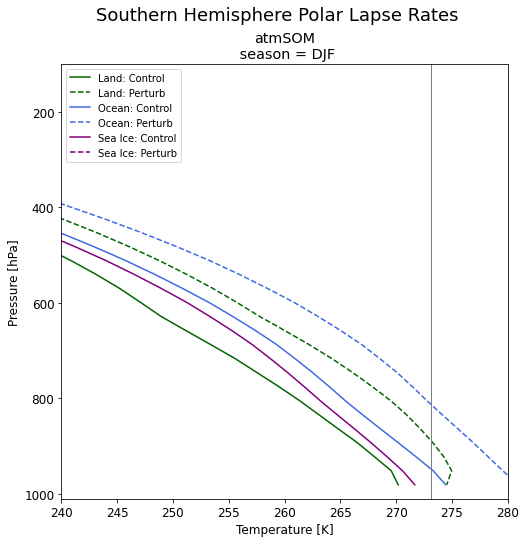

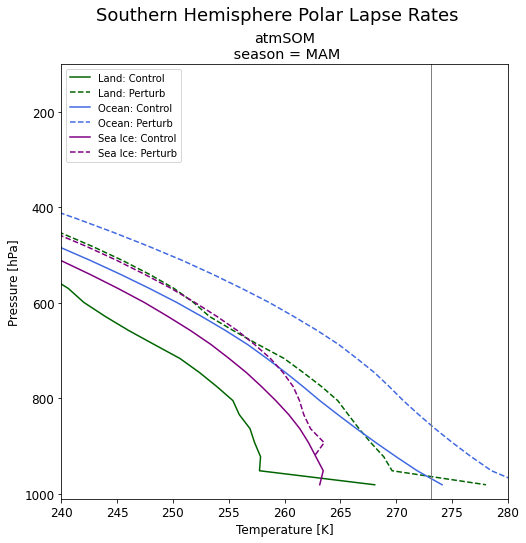

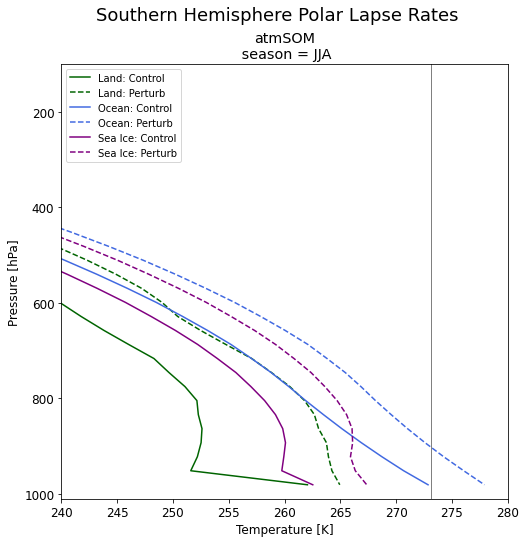

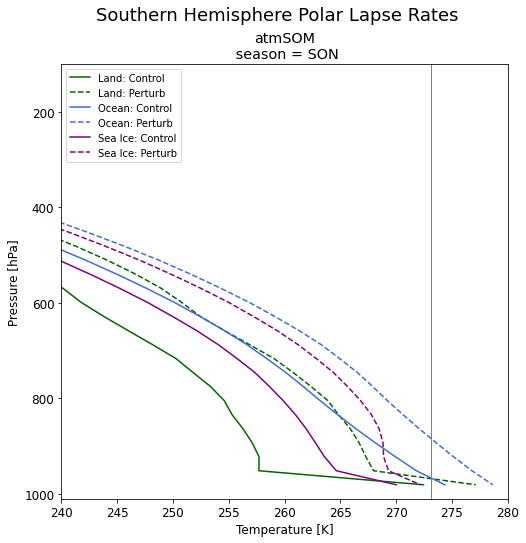

In [147]:
for seas in seasons:
    plot_temp_profiles(Tpres_c, Tpres_p, hemi , seas, latbound = 60, ylim = 100, xlim = [240, 280], fixed = 0)

Fixed Area Plots

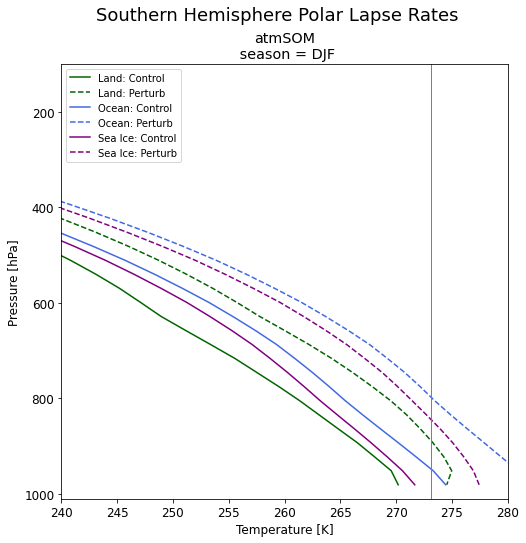

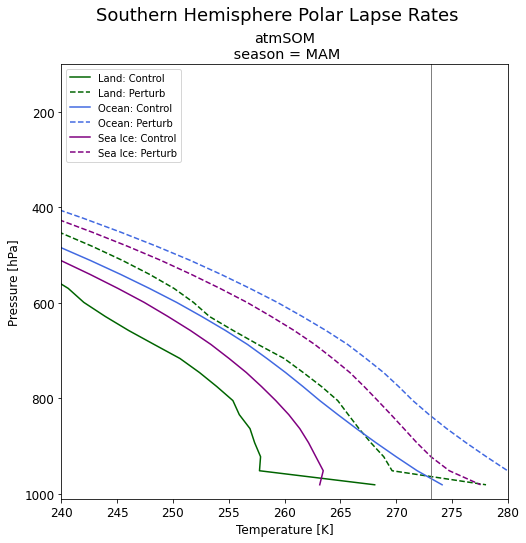

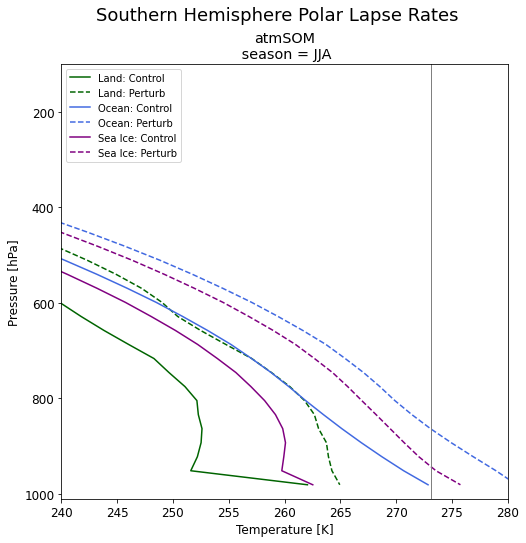

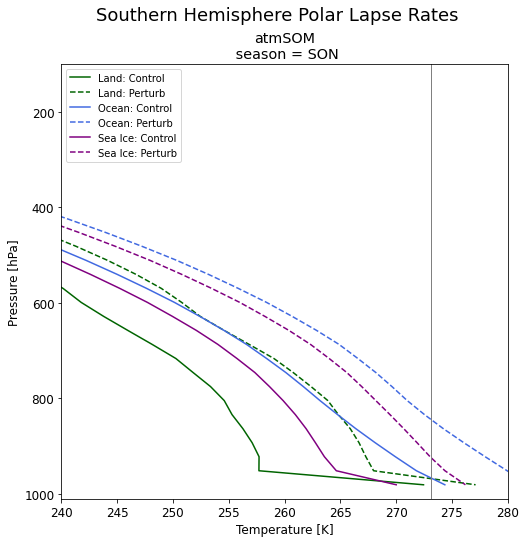

In [28]:
for seas in seasons:
    plot_temp_profiles(Tpres_c, Tpres_p, hemi, seas, latbound = 60, ylim = 100, xlim = [240, 280], fixed = 1)

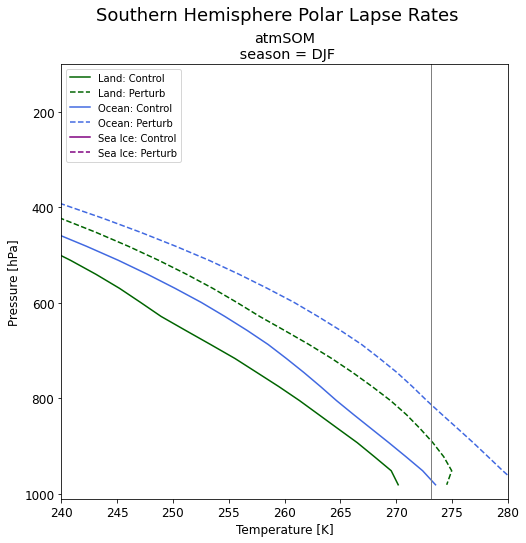

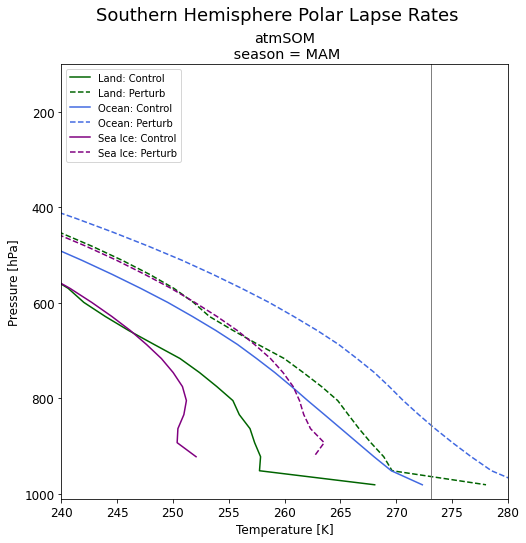

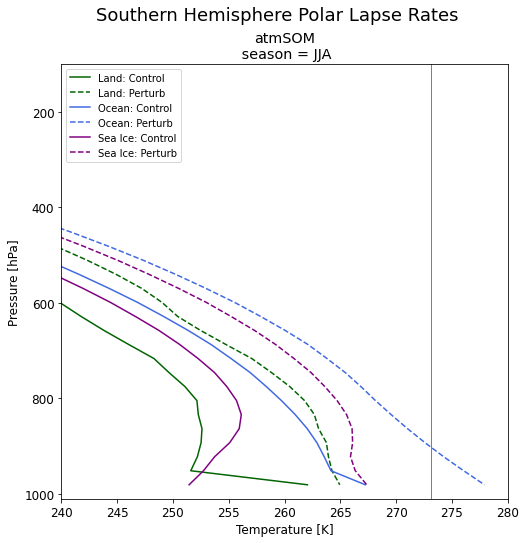

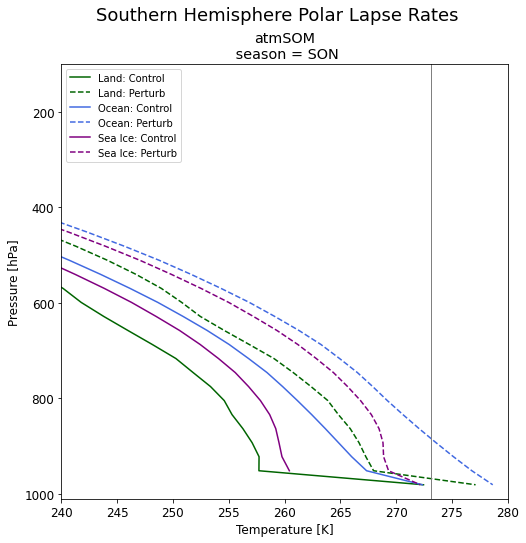

In [29]:
for seas in seasons:
    plot_temp_profiles(Tpres_c, Tpres_p, hemi, seas, latbound = 60, ylim = 100, xlim = [240, 280], fixed = 2)

### Cookie Sheet figures

### Inversions

### Radiative Kernels

Pressure levels : (1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 70, 50, 30, 20, 10, 5, 1 hPa).

Kernels coming from: Smith, C. J., Kramer, R. J., and Sima, A.: The HadGEM3-GA7.1 radiative kernel: the importance of a well-resolved stratosphere, Earth Syst. Sci. Data, 12, 2157–2168, https://doi.org/10.5194/essd-12-2157-2020, 2020

We'll need a regridding function (take our output to the appropriate pressure levels) and regrid the kernel to our grid...

This stuff should get maybe get moved to a new notebook, deals with different files? Need to take a better look at variables in the cam output files 

In [32]:
TOA_kernels = xr.open_dataset('HadGEM3-GA7.1_TOA_kernel_L19.nc')
surf_kernels = xr.open_dataset('HadGEM3-GA7.1_srf_kernel_L19.nc')

In [149]:
def plot_kernels(surf_kernels, TOA_kernels, kernel, month):
    fig,axs = plt.subplots(ncols=3, figsize=(20,5))
    
    diff =  TOA_kernels[kernel] - surf_kernels[kernel]
    vmax = 0
    vmin = -3
    
    vmax2 = 0.5
    vmin2 = -0.5
    
    if kernel == 'ta_lw':
        surf_kernels = surf_kernels.mean(dim = 'lon')
        TOA_kernels = TOA_kernels.mean(dim = 'lon')
        diff =  TOA_kernels[kernel] - surf_kernels[kernel]
        
        vmax = 2
        vmin = -2
        
    if kernel == 'tsurf_lw':
        vmax = 0
        vmin = -7
        
        vmax2 = 5
        vmin2 = -5
        
    if month == 'mean':
        surf_kernels[kernel].mean(dim='month').plot.imshow(ax = axs[0], vmin = vmin, vmax = vmax, cmap = cm.Blues_r)
        TOA_kernels[kernel].mean(dim='month').plot.imshow(ax = axs[1], vmin = vmin, vmax = vmax, cmap = cm.Blues_r)
        diff.mean(dim='month').plot.imshow(ax = axs[2], vmin = vmin2, vmax = vmax2, cmap = cm.RdBu_r)
    else:
        surf_kernels[kernel].isel(month=month).plot.imshow(ax = axs[0],vmin = vmin, vmax = vmax,cmap = cm.Blues_r)
        TOA_kernels[kernel].isel(month=month).plot.imshow(ax = axs[1],vmin = vmin,vmax = vmax,cmap = cm.Blues_r)
        diff.isel(month=month).plot.imshow(ax = axs[2], vmin = vmin2, vmax = vmax2, cmap = cm.RdBu_r)
    
    axs[0].set_title('Surface ' + kernel.capitalize() + ' Kernel,' + str(month))
    axs[1].set_title('TOA '+ kernel.capitalize() + ' Kernel,' +str(month))
    axs[2].set_title('Difference')
    

def regrid_kernels(surf_kernels, TOA_kernels):
    return("NotYetImplemented")

# vertical_regrid defined at TOP!
ptarget = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 70, 50, 30, 20, 10, 5, 1]



In [141]:
regrid_kernels(surf_kernels,TOA_kernels)

'NotYetImplemented'

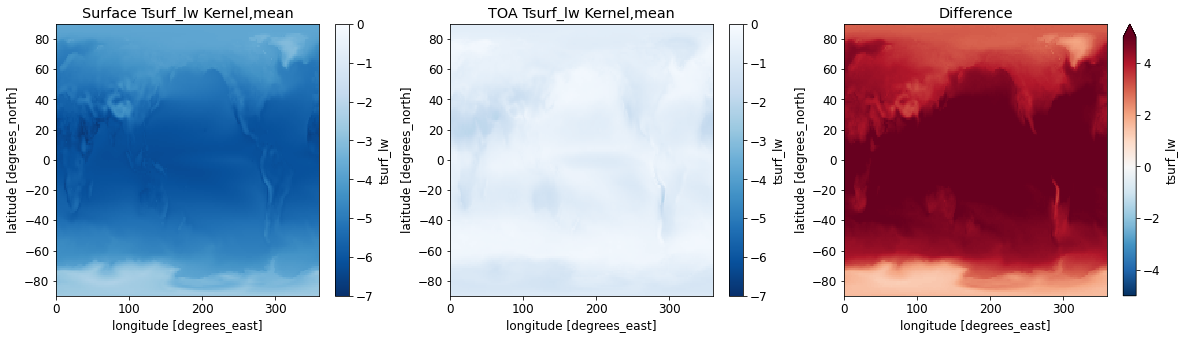

In [137]:
plot_kernels(surf_kernels, TOA_kernels, 'tsurf_lw', 'mean')

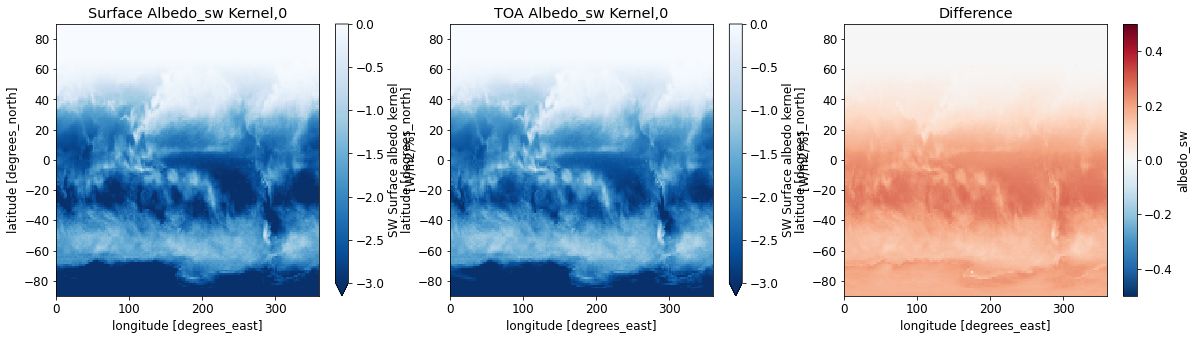

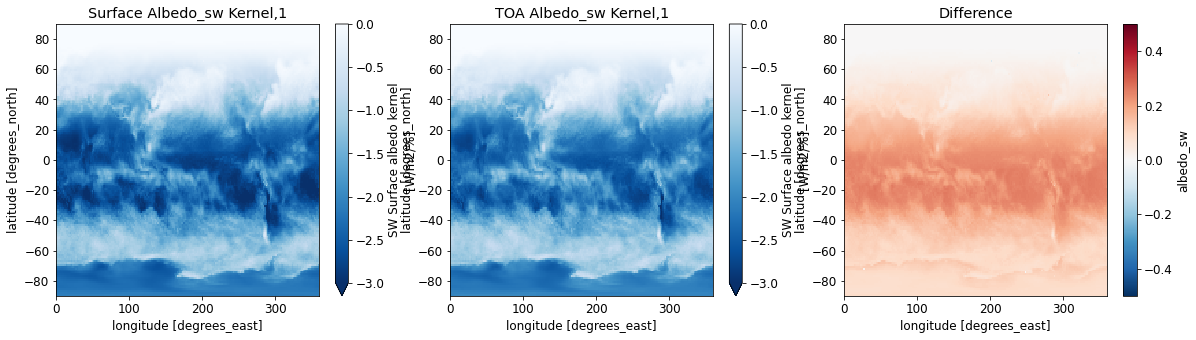

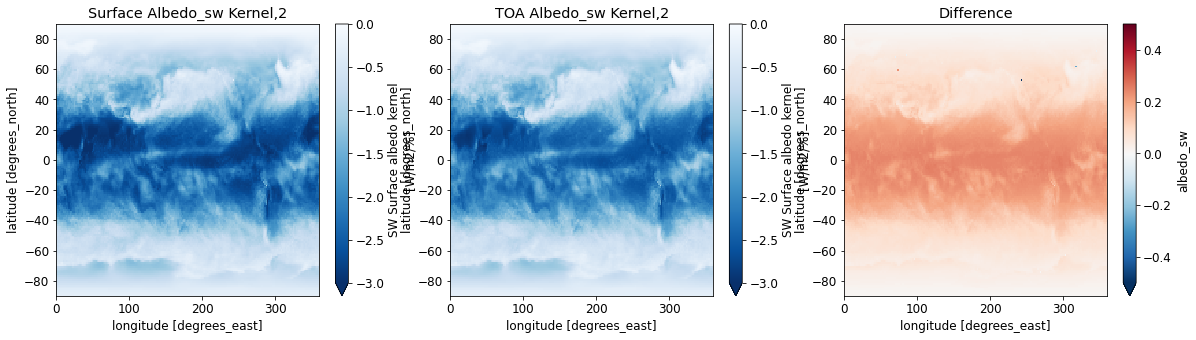

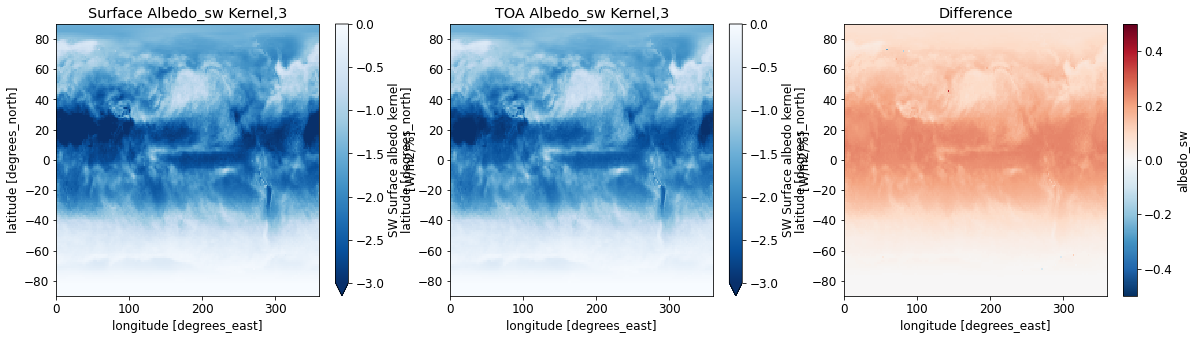

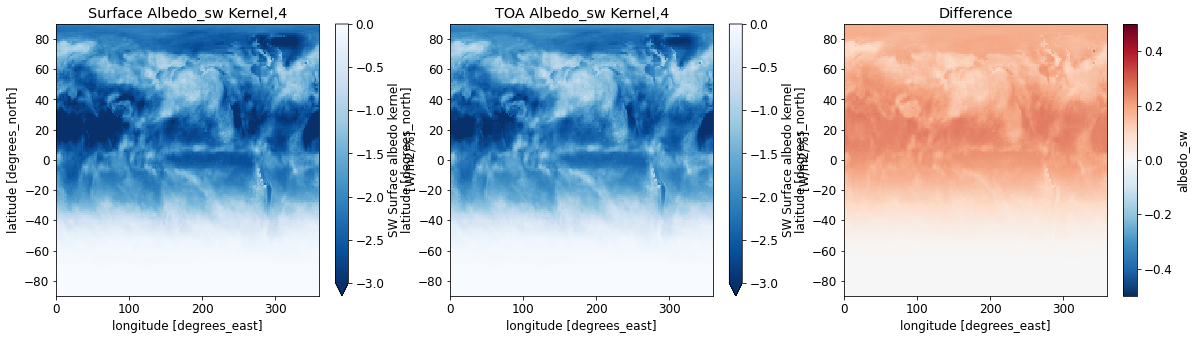

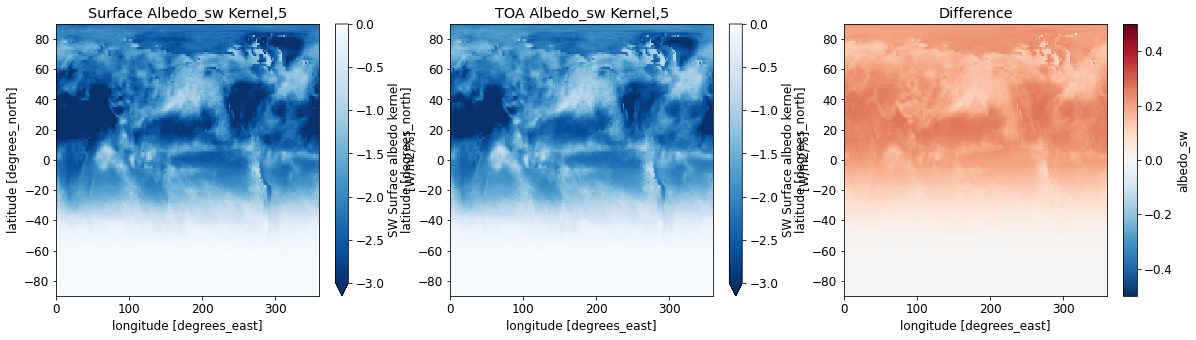

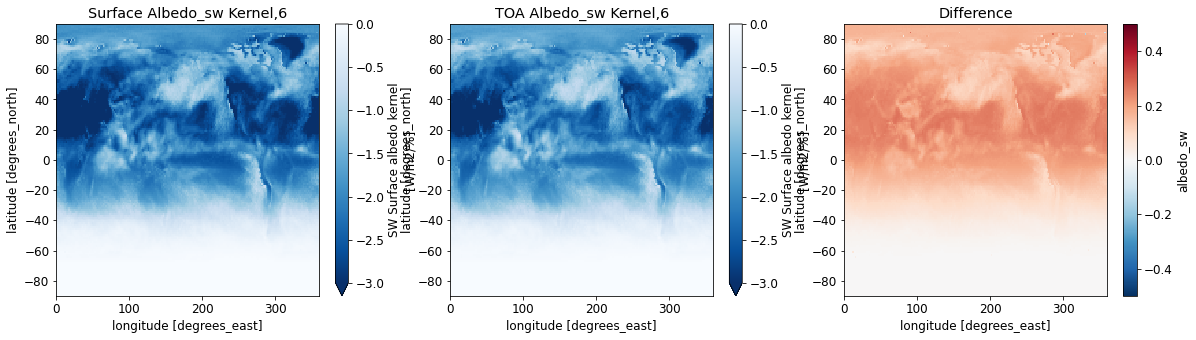

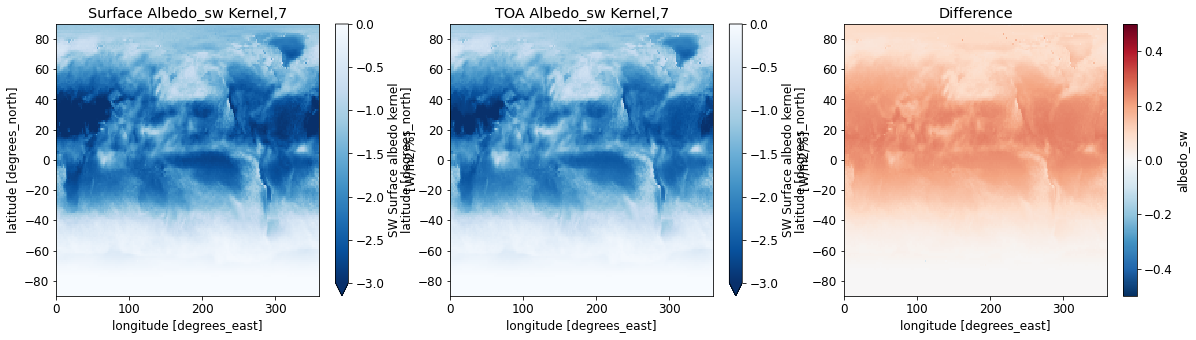

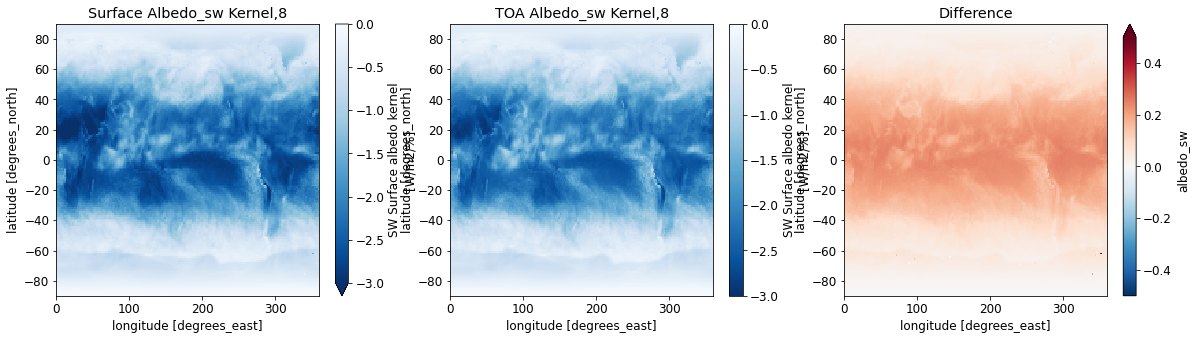

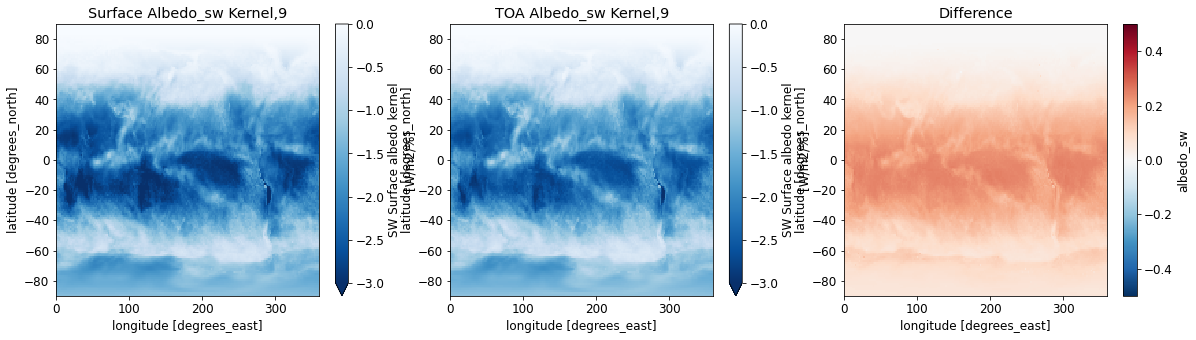

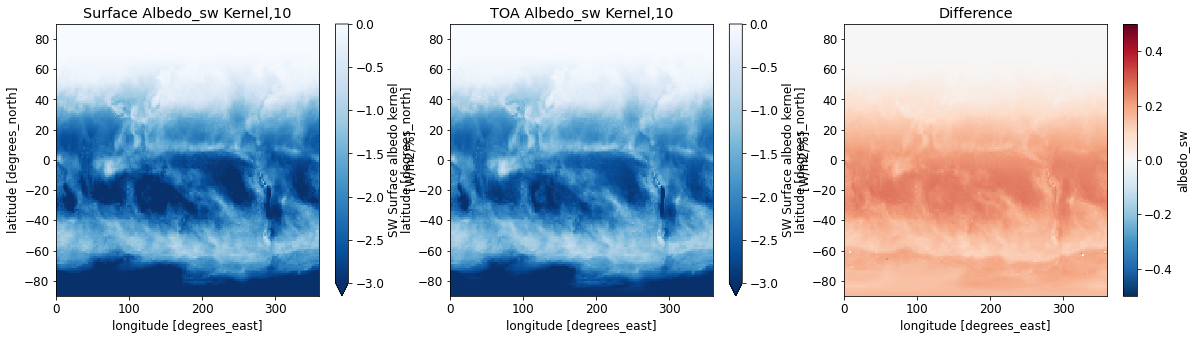

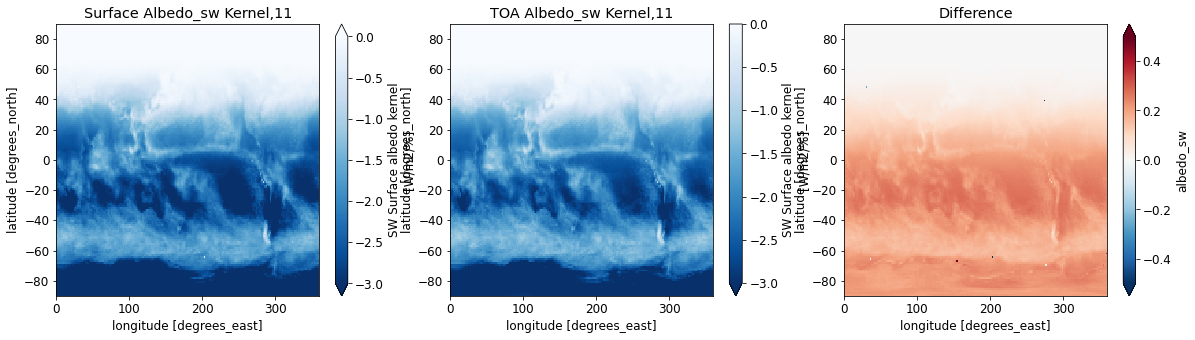

In [117]:
for month in range(0,12):
    plot_kernels(surf_kernels,TOA_kernels,'albedo_sw', month)

In [150]:
ds

<xarray.Dataset>
Dimensions:       (ilev: 33, lat: 96, lev: 32, lon: 144, nbnd: 2, time: 360)
Coordinates:
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time          (time) object 0121-02-01 00:00:00 ... 0151-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    FSNT          (time, lat, lon) float32 ...
    P0            float64 ...
    ch4vmr        (time) float64 ...
    co2vmr        (time) float64 ...
    date          (time) float64 ...
    date_written  (time) object ...
    datesec       (time) float64 ...
    f11vmr        (time) float64 ...
    f12vmr        (time) float64 ...
    gw            (lat) float64 ...
    hyai          (ilev) float64 ...
    hyam          (lev) float64 ...
    hybi          (ilev) float64 ...
    hybm          (lev) float64 ...
    mdt           float64 ...
    n2ovmr        (time) float64 ...
    nbdate        float64 ...
    nbsec         float64 ...
    ndbase        float64 ...
    ndcur         (time) float64 ...
    nsbase        float64 ...
    nscur         (time) float64 ...
    nsteph        (time) float64 ...
    sol_tsi       (time) float64 ...
    time_bnds     (time, nbnd) float64 ...
    time_written  (time) object ...
    CCN3          (time, lev, lat, lon) float32 ...
    CLDLOW        (time, lat, lon) float32 ...
    FLDS          (time, lat, lon) float32 ...
    FLNS          (time, lat, lon) float32 ...
    FLNSC         (time, lat, lon) float32 ...
    FLNT          (time, lat, lon) float32 ...
    FLNTC         (time, lat, lon) float32 ...
    FSDS          (time, lat, lon) float32 ...
    FSNS          (time, lat, lon) float32 ...
    FSNTOA        (time, lat, lon) float32 ...
    ICEFRAC       (time, lat, lon) float32 ...
    LWCF          (time, lat, lon) float32 ...
    U             (time, lev, lat, lon) float32 ...
    V             (time, lev, lat, lon) float32 ...
    OMEGA         (time, lev, lat, lon) float32 ...
    PS            (time, lat, lon) float32 ...
    QFLX          (time, lat, lon) float32 ...
    SFDMS         (time, lat, lon) float32 ...
    SHFLX         (time, lat, lon) float32 ...
    T             (time, lev, lat, lon) float32 ...
    TS            (time, lat, lon) float32 ...
    RESTOM        (time, lat, lon) float32 -43.726135 -43.633255 ... -161.52734
    mask          (lat, lon) int32 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    Conventions:                CF-1.0
    source:                     CAM
    case:                       atmSpScontrol
    logname:                    vcooper
    host:                       cheyenne2
    initial_file:               /glade/scratch/cmip6/b.e21.BHIST.f19_g17.CMIP...
    topography_file:            /glade/p/cesmdata/cseg/inputdata/atm/cam/topo...
    model_doi_url:              https://doi.org/10.5065/D67H1H0V
    time_period_freq:           month_1
    history:                    Mon Nov 23 12:06:27 2020: ncks -C -A -v TS /g...
    NCO:                        netCDF Operators version 4.7.9 (Homepage = ht...
    history_of_appended_files:  Mon Nov 23 12:06:27 2020: Appended file /glad...

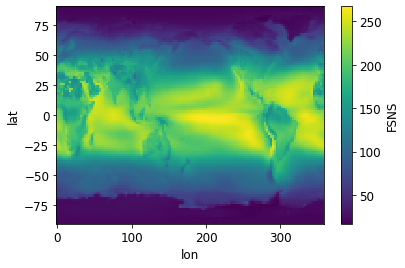

In [151]:
ds.FSNS.mean(dim = 'time').plot.imshow()

Following Zhang et al. (2011), we define surface-based inversion depth as the geopotential thickness between the surface pressure and 
the first pressure level above which temperature decreases with height, and inversion intensity as the difference in temperature between these two levels.

In [44]:
#LILY'S FUNCTION FOR INVERSION STRENGTH --> Take this into python
case = "atmSOMcontrol"
tseries_dir = "/glade/scratch/mollyw/archive/" + case + "/atm/proc/tseries/month_1/"
period = ".002201-003012.nc"

file = tseries_dir + case + '.cam.h0'

def inversion_strength(file, tseries_dir, period):
    
    dsT = xr.open_dataset(file + '.T' + period )
    # grab Z3 for depth
    dsZ = xr.open_dataset(file + '.Z3' + period )
    # grab surface pressure 
#     dsPS = xr.open_dataset(file + '.PS' + period )
#     dsPS = dsPS.PS/100

#     dsT = dsT.merge(dsPS)
#     dsZ = dsZ.merge(dsPS)
 
    # interpolate to 10 hPa resolution 
    ptarget = np.arange(1,1000,10)
    
    dsT = dsT.interp(lev=ptarget)
    dsZ = dsZ.interp(lev=ptarget)
    
    
    dsT['T'] = dsT.T - 273.15 # might need to adjust this to only subtract from temperature 
    
    # select for the Arctic pole's lower troposphere
    ind = (xr.ufuncs.fabs(dsT.lev.values - 500)).argmin()
    
    dsT = dsT.sel(lat = slice(59,90)).isel(lev = slice(ind, -1))
    dsZ = dsZ.sel(lat = slice(59,90)).isel(lev = slice(ind, -1))
#     dsPS = dsPS.sel(lat = slice(59,90))

    # find first level where decrease T
    dTdz = dsT.T.diff(dim = 'lev') # defined negative for an inversion
    dTdz = dTdz.rename('dT')

    ds = xr.merge([dsT,dsZ,dTdz])
    
    # replace positive values with a fill value
    dT = ds.dT.where(ds.dT > 0, -88888)
    
    inv_top = dT.argmax(dim='lev')
    inv_top = inv_top.rename('index')
    
    # isolate surface temperature 
    surf_temp = ds.T.isel(lev = -1).where(inv_top != 0.)
    surf_Z3 = ds.Z3.isel(lev = -1).where(inv_top != 0.)

    
    # now subtract the temperature and gph at the surface from temperature and gph at the top of the inversion
    intensity = ds.T.isel(lev = inv_top).where(inv_top!=0.) - surf_temp
    depth = ds.Z3.isel(lev = inv_top).where(inv_top!=0.) - surf_Z3
    
    return intensity, depth
    



In [45]:
intensity,depth = inversion_strength(file, tseries_dir, period)

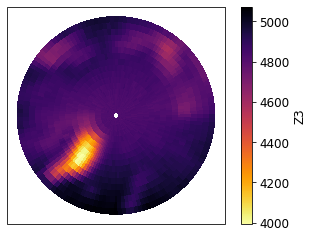

In [46]:
DEPTH = depth.mean(dim = 'time')

map_proj = ccrs.NorthPolarStereo()

DEPTH.plot(transform=ccrs.PlateCarree(), subplot_kws={'projection': map_proj}, cmap = cm.inferno_r)

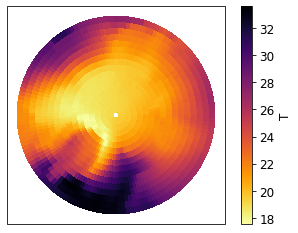

In [47]:
INTENSITY = xr.ufuncs.fabs(intensity.mean(dim = 'time'))

map_proj = ccrs.NorthPolarStereo()

INTENSITY.plot(transform=ccrs.PlateCarree(), subplot_kws={'projection': map_proj}, cmap = cm.inferno_r)